# Autoecoder

WE'll get familiar with the concept of convolutional autoencoders



## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.


![Autoencoders](https://drive.google.com/uc?export=view&id=18iU9_yZfqs2QlTPbaibzkMtdIekLuPj2)

As we can see, the autoencoder is divided roughly in two parts: the encoder that encodes the input to a "code", or internal representation, that is reduced in dimensions, and the decoder that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function h(x)≈x. In other words, it is trying to learn an approximation to the identity function, so as to output x'  that is similar to x. This may sound like a pretty trivial task, why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### In this project, we will be building a denoising autoencoder. The input of the autoencoder will be a noisy version of our training data and we will train the model to predict the noise free version. 

## Transposed-Convolution
Conceptually, transposed-convolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while transposed-convolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2 *going from bigger to smaller*:
![convolution.gif](https://drive.google.com/uc?export=view&id=1TjSgMinNQ629TrdEmcVjKuwWZ9MGMfg7)

#### Transposed-Convolution (convolution with fractional stride) *going from smaller to bigger*:
![deconvolution.gif](https://drive.google.com/uc?export=view&id=1opzIaiShA5_nLT5Y5Kh_GqPT9IlVeQF5)

As we can see, transposed-convolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.
Concretely, this is how we implement transposed-convolution in tensorflow:

In [1]:
tf.nn.conv2d_transpose(
    value, # input tensor: A 4-D Tensor of type float and shape [batch, height, width, in_channels]
    filter, # filter tensor: A 4-D Tensor with shape [height, width, output_channels, in_channels]
    output_shape, # A 1-D Tensor representing the output shape of the transposed-convolution op.
    strides, # A list of ints. The stride of the sliding window for each dimension of the input tensor.
    padding='SAME'
)

NameError: ignored

In [3]:
# This makes sure that we are using Tensorflow 2
try:
  # Note: %tensorflow_version only exists in Google Colab
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.5.0
GPU Available:  True


## Noise Functions

In order to test our autoencoder, we need to add some noise to our MNIST data points. The goal for the autoencoder is to learn the important underlying features (the numbers) of the data and to ignore the extra noise. 

Implement the below different noise functions.

In [4]:
"""
This function adds no noise, we use this as a way of comparing the 
autoencoder when there's no input noise
"""
def no_noise(x):
  x = tf.dtypes.cast(x, tf.float32)
  return x

"""
This function should add a random uniform tensor of the shape of x between 
-0.3 to 0.3 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_noise(x):
  x = tf.dtypes.cast(x, tf.float32)
  noise = tf.random.uniform(x.shape, minval=-0.3, maxval=0.3, dtype=tf.dtypes.float32)
  noised = tf.clip_by_value((x + noise),0,1)
  return noised

"""
This function should multiply a random uniform tensor of the shape of x between 
0 to 2.0 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_scale(x):
  x = tf.dtypes.cast(x, tf.float32)
  noise = tf.random.uniform(x.shape, minval=0, maxval=2.0, dtype=tf.dtypes.float32)
  
  noised = tf.clip_by_value(tf.math.multiply(x,noise),0,1)
  return noised

# some "unit tests"
x = [[0.3,0.1],[0.2,0]]
y = [[0.1,1],[0,0.33]]
result_1 = random_noise(x)
result_2 = random_scale(x)
result_3 = random_noise(y)
result_4 = random_scale(y)

for res in [result_1, result_2, result_3, result_4]:
  assert(res.shape == (2,2))
  assert(res.dtype == tf.float32)
  assert(np.max(np.array(res)) <= 1.0)
  assert(np.min(np.array(res)) >= 0.0)

print("Noise functions look good!")

Noise functions look good!


## Architecture Definition
We want to construct the following architecture:

Shapes:

Layer | Shape of Output
--- | ---
Input | (batch_size, 28, 28, 1)
encoder_conv_1    | (batch_size, 14, 14, 10)
encoder_conv_2    | (batch_size, 7, 7, 10)  
encoder_conv_3    | (batch_size, 4, 4, 10)  
decoder_deconv_1  | (batch_size, 7, 7, 10)  
decoder_deconv_2  | (batch_size, 14, 14, 10)
decoder_deconv_3  | (batch_size, 28, 28, 1)

![Architecture](https://drive.google.com/uc?export=view&id=1GaQ-xZ0lmU8iNTm1IVPo60NyKUAyB9bx)

## **Encoder**
Let's first build the encoding portion of our autoencoder.

In [15]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
       super(Encoder, self).__init__()
       self.encoder_conv_1 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='SAME', kernel_initializer=tf.keras.initializers.random_normal(0,0.1))
       self.encoder_conv_2 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='SAME', kernel_initializer=tf.keras.initializers.random_normal(0,0.1))
       self.encoder_conv_3 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='SAME', kernel_initializer=tf.keras.initializers.random_normal(0,0.1))
       self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    
    @tf.function
    def call(self, images):
        output = self.leaky_relu(self.encoder_conv_1(images))
        output = self.leaky_relu(self.encoder_conv_2(output))
        output = self.leaky_relu(self.encoder_conv_3(output))
        return output

## **Decoder**
Now let's build the decoder portion of our autoencoder.


In [8]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.L1_W = tf.Variable(tf.random.normal([4,4,10,10], stddev=0.1))
        self.L1_b = tf.Variable(tf.random.normal([10], stddev=0.1))
        
        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(filters=10, kernel_size=3, padding='SAME', strides=2, kernel_initializer=tf.keras.initializers.random_normal(0,0.1))
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, padding='SAME', strides=2, kernel_initializer=tf.keras.initializers.random_normal(0,0.1))
        self.decooder_leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    
        
    
    @tf.function
    def call(self, encoder_output):
        
        batchSz = tf.shape(encoder_output)[0]
        deconv = tf.nn.conv2d_transpose(encoder_output, self.L1_W, tf.stack([batchSz, 7, 7, 10]) ,  strides=2, padding='SAME' )
        deconv = tf.add(deconv, self.L1_b)
        results = tf.nn.leaky_relu(deconv)
        
        # TODO rest of transposed-convolution layers
        output = tf.nn.leaky_relu(self.decoder_deconv_2(results))
        output = tf.nn.leaky_relu(self.decoder_deconv_3(output))
        return output

Now let's combine everything to create our autoencoder.

Our loss equation is:
$$\sum (y - x)^2$$


y: the encoded image 

x: the original corrupted image

In [9]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, images):
        enc = self.encoder(images)
        dec = self.decoder(enc)
        return dec
    
    @tf.function
    def loss_function(self, encoded, originals):
      encoded = tf.dtypes.cast(encoded, tf.float32)
      originals = tf.dtypes.cast(originals, tf.float32)
      return tf.reduce_sum((encoded - originals)**2)

## Train loop and Loss

In [10]:
def train(model, optimizer, images, noise_function):
  corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
  
  with tf.GradientTape() as tape:
    res = model.call(corrupted)
    loss = model.loss_function(res, corrupted)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
def total_loss(model, images, noise_function):
  sum_loss = 0
  corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
  predictions = model(corrupted)
  sum_loss += model.loss_function(predictions, corrupted).numpy()
  return sum_loss

## Testing the autoencoder

Run the following code to run the autoencoder. You should see it print out images and the total loss of the autoencoder each epoch.

Be aware that the loss generally should go down each epoch, but might not always. 

It probably will take 2 to 5 minutes (make sure you are using a GPU!)

Showing autoencoder for noise function: <function no_noise at 0x7fbfbd787f80>
Epoch:  0
Total Loss: 81320.15625


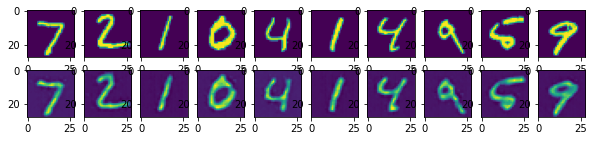

Epoch:  1
Total Loss: 40502.09375


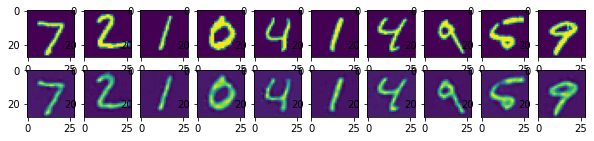

Epoch:  2
Total Loss: 45959.14453125


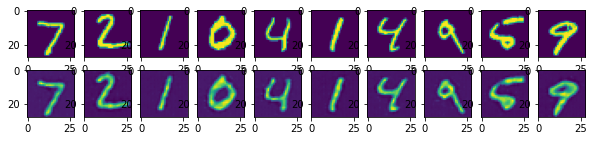

Epoch:  3
Total Loss: 39773.8359375


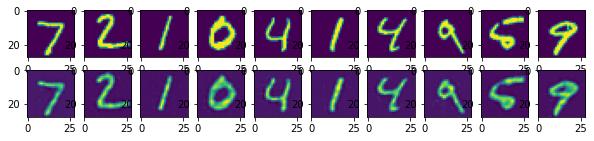

Epoch:  4
Total Loss: 58394.53515625


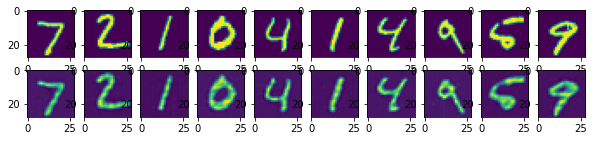

Showing autoencoder for noise function: <function random_scale at 0x7fbfbd7877a0>
Epoch:  0
Total Loss: 148483.875


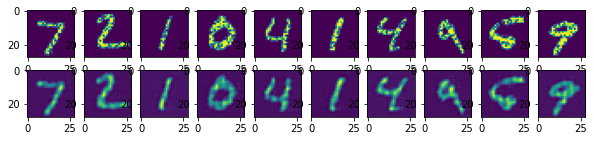

Epoch:  1
Total Loss: 130729.6640625


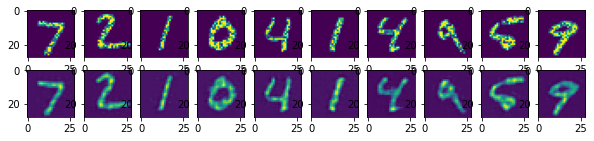

Epoch:  2
Total Loss: 119239.09375


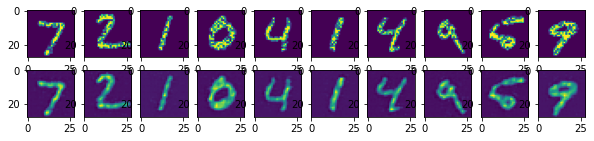

Epoch:  3
Total Loss: 129560.6640625


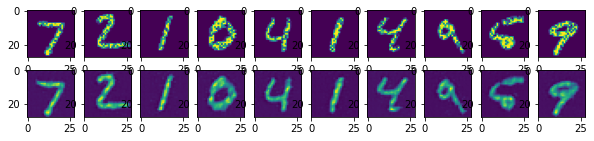

Epoch:  4
Total Loss: 116759.3671875


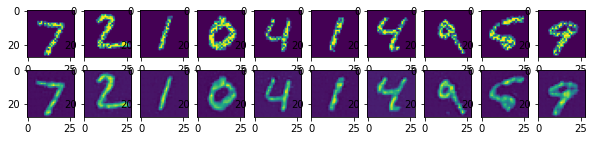

Showing autoencoder for noise function: <function random_noise at 0x7fbfbd787d40>
Epoch:  0
Total Loss: 119970.1875


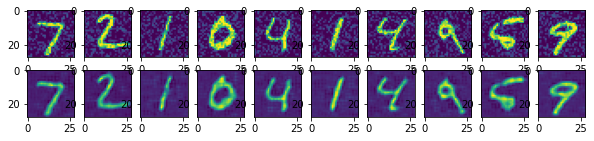

Epoch:  1
Total Loss: 107503.578125


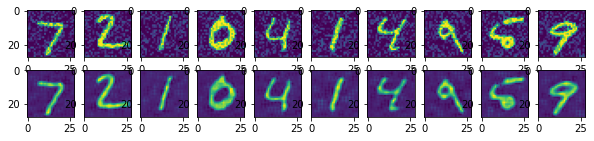

Epoch:  2
Total Loss: 103433.078125


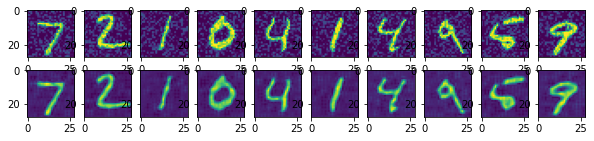

Epoch:  3
Total Loss: 103291.421875


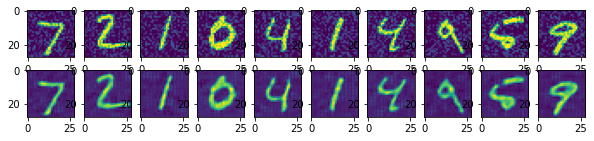

Epoch:  4
Total Loss: 100742.515625


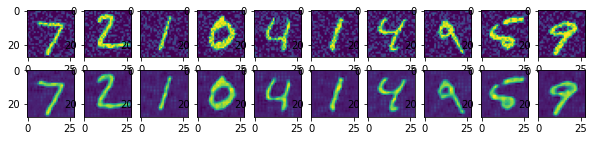

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

n_examples = 10
batch_size = 100
n_epochs = 5

mnist = tf.keras.datasets.mnist

(train_images, _),(test_images,_) = mnist.load_data()
test_images = test_images / 255
example_images = test_images[:n_examples]
train_images = train_images / 255

"""Test the convolutional autoencder using MNIST."""
def showImages(model, noise_function):  

  corrupted = tf.reshape(noise_function(example_images), [-1, 28, 28, 1])
  recon = model(corrupted)

  fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
  for example_i in range(n_examples):
      axs[0][example_i].imshow(
          np.reshape(
              np.reshape(corrupted[example_i, ...], (784,)),
              (28, 28)))
      axs[1][example_i].imshow(
          np.reshape(
              np.reshape(recon[example_i, ...], (784,)),
              (28, 28)))
  plt.show()

# Runs the autoencoder
# Run for each noise function
for noise_function in [no_noise, random_scale, random_noise]:
  print("Showing autoencoder for noise function: {0}".format(noise_function))
  model = AutoEncoder()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

  for i in range(n_epochs):
    for j in range(0, len(train_images), batch_size):
      train(model, optimizer, train_images[j:j+batch_size], noise_function)

    print("Epoch: ", i)
    sum_loss = total_loss(model, test_images, noise_function)
    print("Total Loss: {0}".format(sum_loss))
    showImages(model, noise_function)

## Visualizing the Data Representation

We can now visualize where MNIST data points are positioned in the lower dimensional vector space created by the autoencoder. Run the following cell to view a 2 dimensional projection of this vector space, where each color represents a different MNIST digit. Notice how even though the dimensionality of this space is much lower than the original (160 vs 784), relevant information about the digits is preserved.

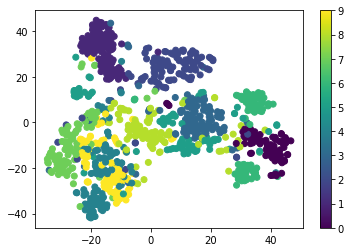

In [17]:
from sklearn.manifold import TSNE

NUM_SAMPLES = 1000

(_, _),(t_images,t_labels) = mnist.load_data()
t_images = t_images[:NUM_SAMPLES]
t_labels = t_labels[:NUM_SAMPLES]
t_images = t_images / 255

z = model.encoder(tf.reshape(random_noise(t_images), [-1, 28, 28, 1]))
z = np.reshape(z, [NUM_SAMPLES, -1])

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(z)
colors = t_labels
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
plt.colorbar()
plt.show()